In [1]:
import pandas as pd
import numpy as np
import math
import os
import cv2
import gc               # library to clear cache

import timm             # library with pretrained models

from fastai.data.all import *
from fastai.vision.all import *
from fastai.metrics import * 

from pathlib import Path
from sklearn.model_selection import train_test_split


In [4]:
# Run the model on the images in this path
image_path='./data/test_images'
image_path='./data/HAM10000_images'

# preprocess into this path
processed_image_path='./data/processed_images'

## Create the dataframe

Creation of the dataframe with images and labels, and a new column to binary classify cancer risk.


In [10]:
# For binary classification (cancer/no_cancer)
def make_dict(df):
    img_to_label_dict = df[["image_id", "label"]].to_dict(orient='list')  
    img_to_label_dict = {img_id : label for img_id,label in zip(img_to_label_dict['image_id'], img_to_label_dict['label']) }
    return img_to_label_dict 

def get_cnc_label_from_dict(path):
    return img_to_label_dict[path.stem]

# Class to make the dataframe from metadata.csv
class acquire_df:
    def __init__(self) -> None:
 
        self.csv_path = "./data/HAM10000_metadata.csv"
        skin_df = pd.read_csv(self.csv_path) 
        skin_df['label']=0
        skin_df.loc[skin_df['dx'].isin(['akiec','bcc','mel']),'label']=int(1)
        
        # Make the dataframe callable
        self.df=skin_df 
        self.img_to_label_dict=make_dict(self.df) 


### FastAI dataloader

- Creates a datablock with images and labels to feed to the model. 
- Does random transformation of images in the dataset to include more variaton. 
- Does random cropping of batches of file to include more variation.

In [11]:

# Class to instantiate the FastAI datablock
class datablock:
    def __init__(self,img_path,batch_size) -> None: 
        
        # Set the path of the image files
        self.img_path=img_path
        img_path = Path(self.img_path)
        Path.BASE_PATH = img_path
 
        # Define the datablock for FastAI
        dblock = DataBlock(

        # Designation of the independent and dependent variables
        blocks = (ImageBlock, CategoryBlock), 

        # To get a list of those files from img_path, get_image_files returns a list of all of the images in that path
        get_items = get_image_files, 
        
        # Split our training and validation sets randomly
        splitter = RandomSplitter(valid_pct=0.2, seed=42) ,

        # We are telling fastai what function to call to create the target in our dataset
        get_y = get_cnc_label_from_dict,

        # VISION AUGMENTATION : add image transformations

        # First resize and then add 8 transformed images to the dataset
        item_tfms=[Resize(448), DihedralItem()],

        # DATA AUGMENTATION

        # First crop and then rescale randomly
        batch_tfms = RandomResizedCrop (size=224, min_scale=0.6, max_scale=1.0)
        )
        self.dls = dblock.dataloaders(img_path, bs=batch_size,num_workers=7, pin_memory=True,device=torch.device('cuda')) # bs = batch size

## Model class

This class creates the model 

#### Defining the optimal learning rate
 Ideally, we want to work in the linear zone, where there is a steepest drop in loss function. We will detect an optimal learning rate by choosing the valley, but also print the steepest and minimum loss points.


In [12]:
# Class to instantiate the model 
class model:
    def __init__(self,model,metrics,batch_size, fine_tune, calculate_lr, unfreeze_weights, nr_unfreeze_layers,epochs) -> None:
        
        self.model=model
        self.metrics=metrics 

        # Clear cache and CUDA memory
        torch.cuda.empty_cache()
        gc.collect()  

        # Create a FastAI datablock from 'image_path'
        block=datablock(image_path,batch_size=batch_size)
        self.dls=block.dls

        #Instantiate learner
        print ('Instantiate learner')     
        self.learn = vision_learner(self.dls,self.model, metrics = self.metrics)  
        print(self.learn.loss_func)
        self.learn.cuda()

        # Calculate optimal learning rate
        if calculate_lr==True:
            print ('Calculating learning rate')
            self.lr_min,self.lr_steep,self.lr_valley,self.lr_slide=lrs = self.learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
            print(f"Minimum/10: {self.lr_min:.2e}\n steepest point: {self.lr_steep:.2e}\n valley point: {self.lr_valley:.2e}\n slide point: {self.lr_slide:.2e}")

            plt.savefig(f'./models/{self.model.__name__}_learning_rate.png')
            plt.show()

        else:
                    
            self.lr_min=3.98e-03*10
            self.lr_steep=2.51e-05*10
                
        if fine_tune==True: 

            # Fine-tune pretrained model
            print ("fine tune pretrained")
            self.learn.fine_tune(epochs, self.lr_valley)

        else: 

            # Unfreeze weights
            print ('Unfreeze and train')
            self.learn.unfreeze()
            
            # print (f'Unfreeze {nr_unfreeze_layers} and train')
            #self.learn.freeze_to(-3)

            # Learn with unfreezed weights
            self.learn.fit_one_cycle(epochs, self.lr_valley)

        # Plot the loss curve
        self.learn.recorder.plot_loss()
        plt.savefig(f'./models/{self.model.__name__}_losses.png')        
        plt.show()
        
        # Save the model
        self.export_model()
        
    # Function to print the models confusion matrix
    def print_confusion_matrix(self):

        interp = ClassificationInterpretation.from_learner(self.learn)
        interp.plot_confusion_matrix(figsize=(6,6), dpi=60)
 
        plt.savefig(f'./models/{self.model.__name__}_confusion_matrix.png')
        plt.show()
        self.conf_matrix = interp.confusion_matrix()
        total = sum(sum(self.conf_matrix))

        print("True Positives: {:.2f}%".format(100 * self.conf_matrix[1, 1] / total))
        print("False Positives: {:.2f}%".format(100 * self.conf_matrix[0, 1] / total))
        print("True Negatives: {:.2f}%".format(100 * self.conf_matrix[0, 0] / total))
        print("False Negatives: {:.2f}%".format(100 * self.conf_matrix[1, 0] / total))
        
        interp.most_confused
        plt.show()

    def print_architecture(self):

        print(self.learn.summary())
    
    # Fuction to save the current models weights 
    def export_model(self):
        self.learn.export(f'./models/{self.model.__name__}_cnc_binarylabels.pkl')

In [13]:

# Create the dataframe
df=acquire_df() 

# Create a dictionary with images and their class
img_to_label_dict = df.img_to_label_dict


## Metrics

We will use metrics that are specifically usefull for binary classification. 

In [15]:
# Metrics
f1_score_multi = F1Score() 
precision=Precision()
recall=Recall()
balancedaccuracy=BalancedAccuracy()


## Choose the parameters for our model

We call the model with the following parameters

| Parameters | explanation |
| :--------- | ----------: |
| model | pretrained model |
| metrics | metrics |
| batch_size | batch size |
| fine_tune | train on the last layer of the pre-trained model |
| calculate_lr | to speed up, set to False |
| unfreeze_weights | unfreeze the pre-trained model |
| nr_unfreeze_layers | Unfreezing only the last (n) layers of pre-trained model |
| epochs | Number of epochs | 

For the scope of this project we will retrain a pre-trained model on our dataset by unfreezing the weights. This gives better results than fine-tuning.

In [16]:
# Metrics
metrics=[accuracy,balancedaccuracy,error_rate]

# Batch size
batch_size=8

# Fine tune the pretrained model
fine_tune=False

# Determine learning rate
calculate_lr=True

# Unfreeze weights or unfreeze only last (n) weights
unfreeze_weights=True
nr_unfreeze_layers=0

# Epochs
epochs=24

## XceptionNet model

For this project we will build a retrained XceptionNet model
 

Instantiate learner
FlattenedLoss of CrossEntropyLoss()
Calculating learning rate


Minimum/10: 6.31e-08
 steepest point: 5.75e-06
 valley point: 1.45e-05
 slide point: 8.32e-04


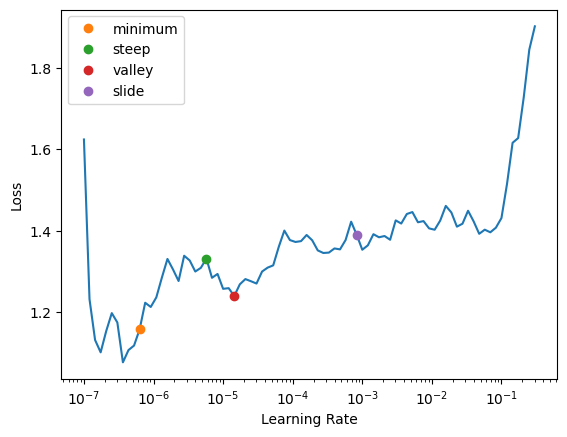

Unfreeze and train


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,error_rate,time
0,1.140225,0.919960,0.548677,0.597474,0.451323,07:07
1,1.139796,0.827390,0.610085,0.685643,0.389915,06:59
2,1.024681,0.626472,0.694958,0.698938,0.305042,06:51
3,0.950843,0.524208,0.756865,0.745165,0.243135,06:50
4,0.863970,0.511034,0.782826,0.774028,0.217174,06:50
5,0.730488,0.450734,0.815776,0.778728,0.184224,06:49
6,0.654603,0.400291,0.837743,0.767777,0.162257,06:49
7,0.553610,0.363818,0.848228,0.765431,0.151772,06:49
8,0.579409,0.324828,0.860709,0.735828,0.139291,06:49
9,0.553976,0.322143,0.871692,0.771130,0.128308,06:49


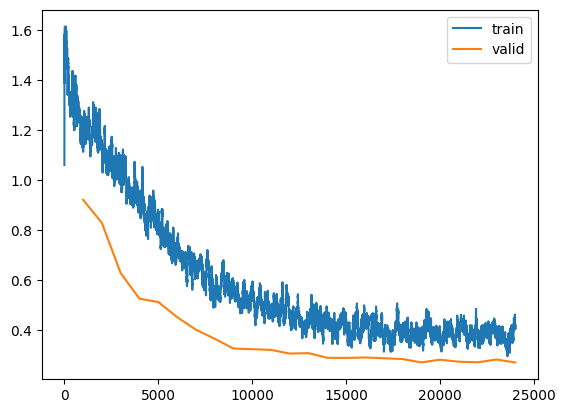

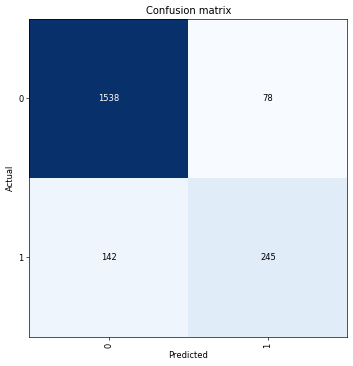

True Positives: 12.23%
False Positives: 3.89%
True Negatives: 76.78%
False Negatives: 7.09%


In [23]:
from timm.models import xception
pretrained_model = xception

model_xception=model(model=pretrained_model,metrics=metrics,batch_size=batch_size,fine_tune=fine_tune,calculate_lr=calculate_lr,unfreeze_weights=unfreeze_weights,nr_unfreeze_layers=nr_unfreeze_layers,epochs=epochs)
model_xception.print_confusion_matrix()

### Print architecture

If necessary, we can print the architecture of the model.

In [ ]:
model_xception.print_architecture() 